## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import models, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/content/drive/MyDrive/datasets/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [5]:
import os
import glob
import random
from PIL import Image
import torch

class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train=True, transform=None, data_path='/content/drive/MyDrive/datasets/hotdog_nothotdog', train_ratio=0.8):
        'Initialization'
        self.transform = transform

        # Load all images from both train and test directories
        all_image_paths = glob.glob(os.path.join(data_path, '*/*/*.jpg'))

        # Split the images into classes
        image_classes = {os.path.split(os.path.split(path)[0])[1]: [] for path in all_image_paths}
        for path in all_image_paths:
            class_name = os.path.split(os.path.split(path)[0])[1]
            image_classes[class_name].append(path)

        # Shuffle and split the dataset based on the specified ratio
        self.image_paths = []
        for class_name, paths in image_classes.items():
            random.shuffle(paths)  # Shuffle the images for randomness
            split_index = int(len(paths) * train_ratio)
            if train:
                self.image_paths.extend(paths[:split_index])  # Training data
            else:
                self.image_paths.extend(paths[split_index:])  # Testing data

        self.name_to_label = {c: id for id, c in enumerate(image_classes.keys())}

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y


Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [6]:
size = 256
# train_transform = transforms.Compose([transforms.Resize((size, size)),
#                                     transforms.ToTensor()])
# test_transform = transforms.Compose([transforms.Resize((size, size)),
#                                     transforms.ToTensor()])

train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),
])

# Transform for the test set (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

batch_size = 64

trainset = Hotdog_NotHotdog(train=True, transform=train_transform, train_ratio=0.8)
testset = Hotdog_NotHotdog(train=False, transform=test_transform, train_ratio=0.8)
# trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path='/content/drive/MyDrive/datasets/hotdog_nothotdog')
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
# testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path='/content/drive/MyDrive/datasets/hotdog_nothotdog')
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's look at some images from our data

In [21]:
# images, labels = next(iter(train_loader))
# plt.figure(figsize=(20,10))

# for i in range(21):
#     plt.subplot(5,7,i+1)
#     plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
#     plt.title(['hotdog', 'not hotdog'][labels[i].item()])
#     plt.axis('off')


In [7]:
import collections

def calculate_class_distribution(dataset):
    class_counts = collections.defaultdict(int)

    for _, label in dataset:
        class_counts[label] += 1  # Use .item() to get the scalar value

    total_samples = sum(class_counts.values())
    class_ratios = {k: v / total_samples for k, v in class_counts.items()}

    return class_counts, class_ratios

# Calculate class distribution for the training set
train_class_counts, train_class_ratios = calculate_class_distribution(trainset)
print("Class Counts (Training):", train_class_counts)
print("Class Ratios (Training):", train_class_ratios)

# Calculate class distribution for the test set
test_class_counts, test_class_ratios = calculate_class_distribution(testset)
print("Class Counts (Testing):", test_class_counts)
print("Class Ratios (Testing):", test_class_ratios)


KeyboardInterrupt: 

Now create a model and train it!


In [8]:
def plot_metrics(out_dict):
    epochs = range(1, len(out_dict['train_acc']) + 1)

    # Plotting the training and testing loss
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, out_dict['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, out_dict['test_loss'], 'r-', label='Testing Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, out_dict['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, out_dict['test_acc'], 'r-', label='Testing Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(8, 8, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(8, 3, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(3, 3, 3, stride=1, padding=1),
                nn.ReLU(),
                )

        self.fully_connected = nn.Sequential(
                nn.Linear(64*64*3, 500),
                nn.ReLU(),
                nn.Linear(500, 1),
                nn.Softmax(dim=1))

    def forward(self, x):

        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x

In [24]:
model = Network()
model.to(device)
#Initialize the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters())

In [25]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
      output = output.squeeze(1)
      target = target.float()
      loss = nn.BCELoss()
      return loss(output, target)

    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), position=0, desc='training loop'):
        # for minibatch_no, (data, target) in enumerate(train_loader):
            # data, target = data.to(device), target.to(device)
            data = data.to(device)
            target = target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)

            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        # print(1)
        model.eval()
        # print(2)
        print("finished training")
        for data, target in tqdm(test_loader, position=1, desc='test loop'):

            data, target = data.to(device), target.to(device)
            # print(3)
            with torch.no_grad():
                output = model(data)
            # print(4)

            # print(output[10:15])
            # print(target[10:15])

            loss = loss_fun(output, target).cpu().item()

            # print(loss)

            test_loss.append(loss)
            # test_loss.append(loss_fun(output, target).cpu().item())

            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            # print(5)
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))

        print(f"Loss \n train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"\n\n Accuracy \n train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [26]:
out_dict = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

training loop:   0%|          | 0/410 [00:00<?, ?it/s]

finished training


test loop:   0%|          | 0/373 [00:00<?, ?it/s]

Loss 
 train: 52.439	 test: 47.989	 

 Accuracy 
 train: 52.5%	 test: 48.1%


training loop:   0%|          | 0/410 [00:00<?, ?it/s]

finished training


test loop:   0%|          | 0/373 [00:00<?, ?it/s]

Loss 
 train: 52.512	 test: 47.989	 

 Accuracy 
 train: 52.5%	 test: 48.1%


training loop:   0%|          | 0/410 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_metrics(out_dict)

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()

        self.convolutional = nn.Sequential(
                nn.Conv2d(n_features, n_features, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(n_features, n_features, 3, stride=1, padding=1),
                nn.ReLU(),
                )

    def forward(self, x):

        conv_output = self.convolutional(x)

        out = conv_output + x

        out = F.relu(out)

        return out

In [ ]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(128, C, 128,128)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

In [ ]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(128*128*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,1),
                                nn.Softmax(dim=1))

    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

In [ ]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict = train(model, optimizer)

In [10]:
model = models.resnet101(weights=None)
model.fc = nn.Linear(model.fc.in_features, 1)  # For binary classification
model.to(device)  # Move model to the device

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
learning_rate = 0.006  # Set your desired learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
criterion = nn.BCEWithLogitsLoss()

In [16]:
# Initialize model
# model = models.resnet18(weights=None)

out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

num_epochs = 10  # Adjust as necessary

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    running_loss = 0.0

    train_correct = 0
    train_loss = []

    for inputs, labels in tqdm(train_loader, position=0, desc='training loop'):
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device

        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels.float())  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        predicted = outputs.argmax(1)
        train_correct += (labels==predicted).sum().cpu().item()

    # Print training loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate the model on the test set
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, position=1, desc='test loop'):
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply sigmoid and threshold
            total += labels.size(0)
            correct += (predicted.squeeze() == labels.float()).sum().item()

            predicted = outputs.argmax(1)

    out_dict['train_acc'].append(train_correct/len(trainset))
    out_dict['test_acc'].append(correct/len(testset))

    # Print test accuracy for the epoch
    print(f'Test Accuracy after epoch {epoch+1}: {100 * correct / total:.2f}%')



  0%|          | 0/10 [00:00<?, ?it/s]

training loop:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10], Loss: 0.7441


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 1: 55.50%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.6457


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 2: 65.98%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.5971


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 3: 64.58%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.5661


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 4: 73.40%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.5567


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 5: 73.53%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.5501


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 6: 68.41%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.5552


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 7: 75.06%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.5477


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 8: 75.06%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.5352


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 9: 73.79%


training loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.5511


test loop:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy after epoch 10: 71.48%


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

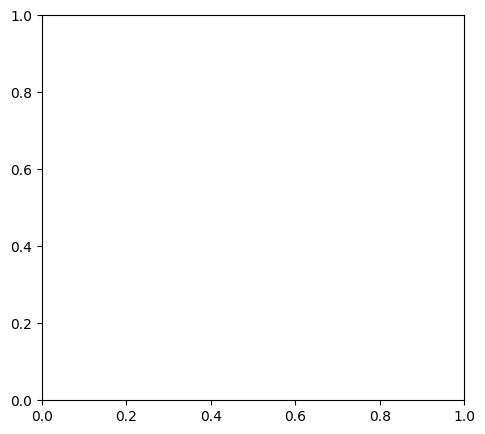

In [17]:
plot_metrics(out_dict)

In [18]:
out_dict

{'train_acc': [0.503997441637352],
 'test_acc': [0.7148337595907929],
 'train_loss': [],
 'test_loss': []}